### Spring ODE

In [233]:
from utils import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import OptimizeResult
import json
import pandas as pd
import warnings
import sys

from cmlCore import *
from cmlUtils import *

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
np.set_printoptions(edgeitems=10, linewidth=100000, threshold=sys.maxsize)

ODE:

$$x''(t)+kx(t)=0$$
$$x(0)=0$$
$$x'(0)=1$$

Solution:
$$x(t)=\sin{\sqrt{k}t}$$

In [234]:
def oneDSpring_ODE_integrable(m=1, k=1, b=0):
    m = m
    k = k
    b = b
    def innerFunc(t, X):    
        x1, x2 = X #x and x'
        dy = np.array([x2, (F-b*x2-k*x1)/m])
        return dy
    return innerFunc

In [235]:
def oneDSpring_ODE_integrable(m=1, k=1, b=0, F=0):
    m = m
    k = k
    b = b
    F = F
    def innerFunc(t, X):    
        x1, x2 = X #x and x'
        dy = np.array([x2, (F-b*x2-k*x1)/m])
        return dy
    return innerFunc

def oneDSpring_ODE_wrapper(m=1, k=1, b=0, F=0):
    callable = oneDSpring_ODE_integrable(m, k, b, F)
    def innerFunc(X):
        return callable(0, X)
    return innerFunc

# analytical solution
def func(k):
    k = k
    def innerFunc(t):
        return np.sin(np.sqrt(k)*t)
    return innerFunc

In [236]:
def euler(func, x0, tf, dt, out_dt=None):
    pers = int((tf/dt))
    tt = dt*np.arange(0, pers+1)
    out = np.zeros((pers+1, len(x0)))
    out[0] = x0
    for i in range(0,pers):
        out[i+1] = out[i] + dt*func(tt[i],out[i])
    if out_dt != None:
        s = int(out_dt/dt)
        tt = tt[::s]
        out = out[::s]
    return OptimizeResult(t=tt, y=out.T)

In [237]:
t0 = 0
tf = 1000
dt = 0.01
tt = np.arange(t0,tf+dt,dt)
y0 = [0, 1]

m_true = 1
k_true = 1
b_true = 0
F_true = 0

m_flawed = 1
k_flawed = 1.01 #1.01
b_flawed = 0
F_flawed = 0

RK45_true = solve_ivp(oneDSpring_ODE_integrable(m=m_true,k=k_true,b=b_true,F=F_true), (t0, tf+dt), y0, method='RK45', t_eval = tt, max_step = 0.01, vectorized=True)
RK45_flawed = solve_ivp(oneDSpring_ODE_integrable(m=m_flawed,k=k_flawed,b=b_flawed,F=F_flawed), (t0, tf+dt), y0, method='RK45', t_eval = tt, max_step = 0.01, vectorized=True)

euler_true = euler(oneDSpring_ODE_integrable(m=m_true,k=k_true,b=b_true,F=F_true), y0, tf, 1e-4, 1e-2)
euler_flawed = euler(oneDSpring_ODE_integrable(m=m_flawed,k=k_flawed,b=b_flawed,F=F_flawed), y0, tf, 1e-4, 1e-2)

analytic_true = np.array([func(k_true)(t) for t in tt])
analytic_flawed = np.array([func(k_flawed)(t) for t in tt])

sol_true = euler_true
sol_flawed = euler_flawed

sol_true = RK45_true
sol_flawed = RK45_flawed

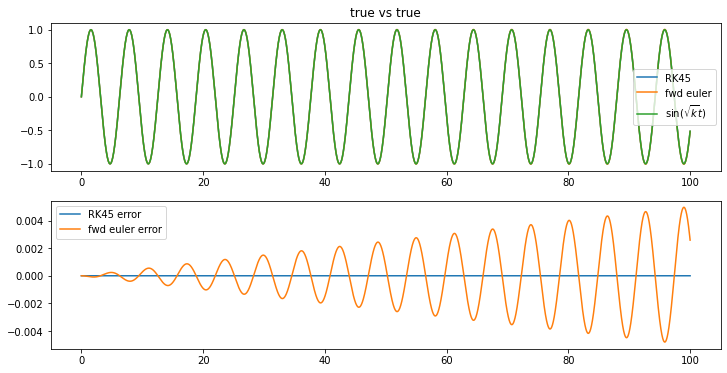

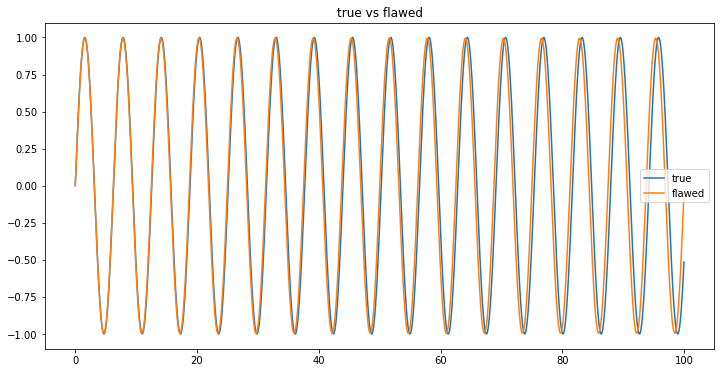

In [238]:
pts_to_show = 10000

fig, axs = plt.subplots(2, figsize=(12,6))
axs[0].plot(tt[:pts_to_show], RK45_true.y[0][:pts_to_show], label="RK45")
axs[0].plot(tt[:pts_to_show], euler_true.y[0][:pts_to_show], label="fwd euler")
axs[0].plot(tt[:pts_to_show], analytic_true[:pts_to_show], label=r'$\sin(\sqrt{k}t)$')
axs[1].plot(tt[:pts_to_show], analytic_true[:pts_to_show]-RK45_true.y[0][:pts_to_show], label="RK45 error")
axs[1].plot(tt[:pts_to_show], analytic_true[:pts_to_show]-euler_true.y[0][:pts_to_show], label="fwd euler error")
axs[0].set_title("true vs true")
axs[0].legend()
axs[1].legend()
plt.show()

fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(tt[:pts_to_show], sol_true.y[0][:pts_to_show], label="true")
ax.plot(tt[:pts_to_show], sol_flawed.y[0][:pts_to_show], label="flawed")
ax.set_title("true vs flawed")
ax.legend()
plt.show()

In [239]:
true_data = sol_true.y.T
true_target = sol_true.y.T[1:]
flawed_data = sol_flawed.y.T
flawed_target = sol_flawed.y.T[1:]

# k=4
# k=8
# k=12
# k=16
k=32

train_start=1000
train_end=11000
test_start=train_end
test_end=100000

training_target = true_target[train_start:train_end]
test_target = true_target[test_start:test_end]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

train_indices.shape, test_indices.shape

((10000,), (89000,))

In [240]:
model = NVARModel(k=k, s=4, reg=1e-5, nonlinearFunc=quadraticCombination, natural_dt=dt) # k=4 -> 94 "units"

In [241]:
nvar_rows(true_data.shape[1],k)

2145

In [242]:
model.train(
        true_data,
        true_target,
        # flawed_data,
        # flawed_target,
        train_indices,
        dataLossFactor=1,
        ODELossFactor=0,
        # ODEFunc=oneDSpring_ODE_wrapper(m=m_true,k=k_true,b=b_true,F=F_true),
        ODEFunc=oneDSpring_ODE_wrapper(m=m_flawed,k=k_flawed,b=b_flawed,F=F_flawed),
        printResults=True
        )

                    MSE     NMSE     NRMSE     Loss Weighted Loss
Component                                                        
Data           0.000000 0.000000 22.501732 0.000000      0.000000
ODE            0.000050 0.000050  0.709784 0.503692      0.000000
Regularization 0.000015 0.000015  0.003817 0.062500      0.000001
Total          0.000065 0.000064 23.215333 0.566192      0.000001


Training only on data loss on true data predicts true data well.

valid time : 8000
NMSE       : 9.999916626214212e-05
RMSE       : 0.009999958312978572
NRMSE      : 4499306512.0186615


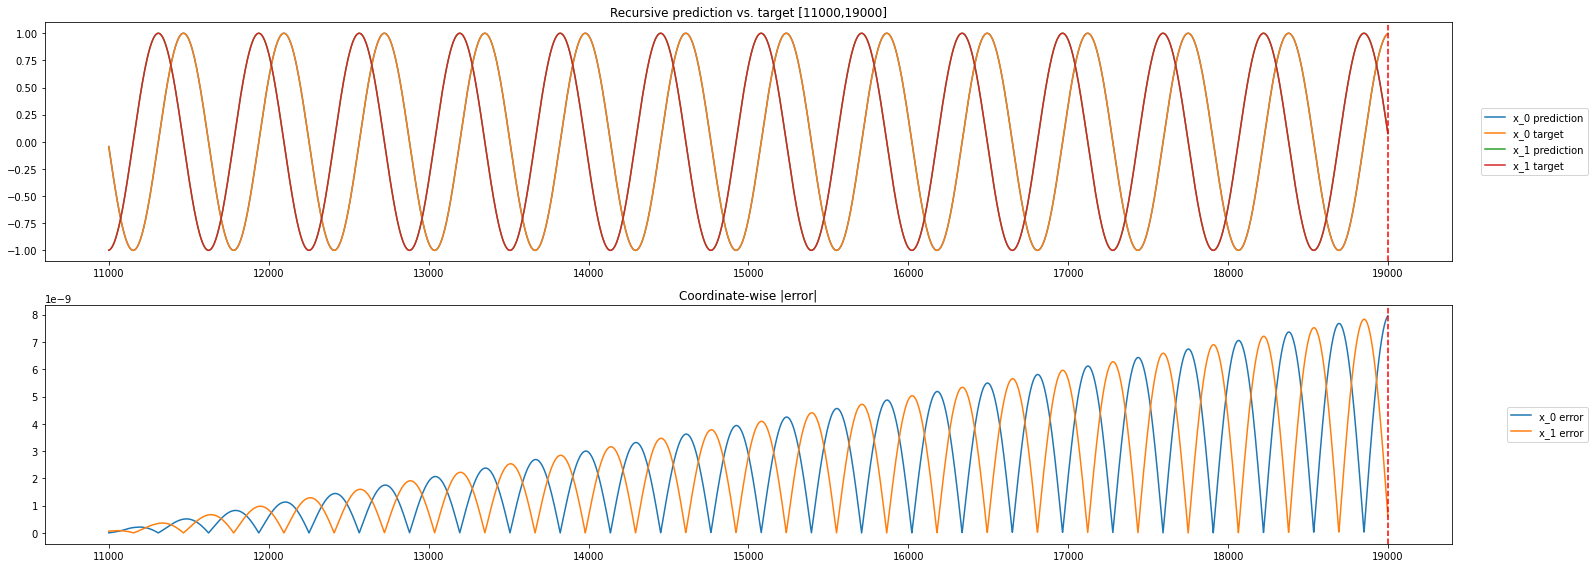

In [243]:
t_forward = 8000
model_rec_out = model.recursive_predict(true_data, train_start, train_end, t_forward)
# model_rec_out = model.recursive_predict(flawed_data, train_start, train_end, t_forward)

vt = validTime(0.2)(model_rec_out, true_target[test_start:test_start+t_forward])
# vt = validTime(0.2)(model_rec_out, flawed_target[test_start:test_start+t_forward])

print(f'valid time : {vt}')
print(f'NMSE       : {NMSE(model_rec_out, true_target[test_start:test_start+t_forward])}')
print(f'RMSE       : {RMSE(model_rec_out, true_target[test_start:test_start+t_forward])}')
print(f'NRMSE      : {NRMSE(model_rec_out, true_target[test_start:test_start+t_forward])}')
plotRecursiveComparison(model_rec_out, true_data, train_end, t_forward, vline_x=test_start+vt)
# plotRecursiveComparison(model_rec_out, flawed_data, train_end, t_forward, vline_x=test_start+vt)

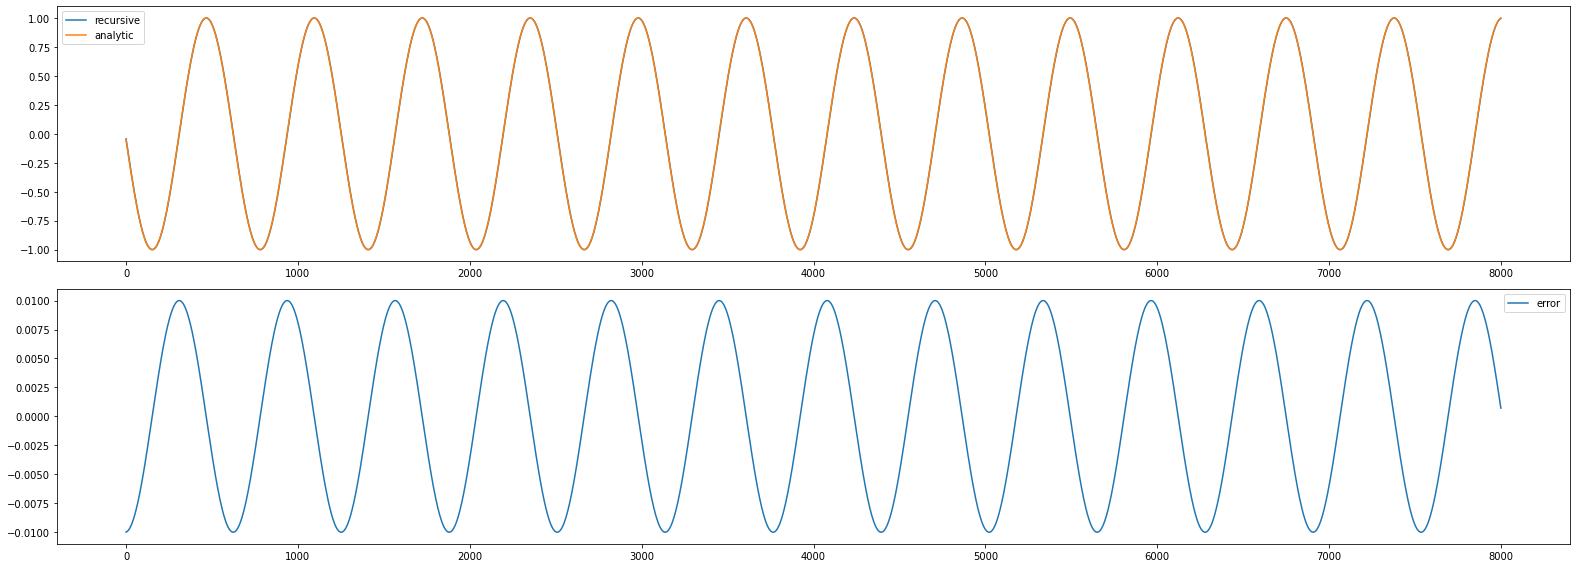

In [244]:
tf = int(t_forward*dt)
rec_x0 = true_data[train_end]
rec_true_data = solve_ivp(oneDSpring_ODE_integrable(m=m_true,k=k_true,b=b_true,F=F_true), (0, tf+dt), rec_x0, method='RK45', t_eval = np.arange(0,tf+dt,dt), max_step = 0.01, vectorized=True).y.T
# adj_true_data = euler(oneDSpring_ODE_integrable(m=m_true,k=k_true,b=b_true,F=F_true), flawed_x0, tf, 1e-4, 1e-2).y.T
rec_true_target = rec_true_data[1:]

fig, axs = plt.subplots(2, figsize=(22,8))
axs[0].plot(np.arange(t_forward), model_rec_out[:t_forward,0], label="recursive")
axs[0].plot(np.arange(t_forward), rec_true_target[:t_forward,0], label="analytic")
axs[1].plot(np.arange(t_forward), rec_true_target[:t_forward,0]-model_rec_out[:t_forward,0], label="error")
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()

Training only on ODE loss on true data predicts true data slightly worse (but still very good)

In [256]:
model.train(
        true_data,
        true_target,
        # flawed_data,
        # flawed_target,
        train_indices,
        dataLossFactor=0,
        ODELossFactor=1,
        ODEFunc=oneDSpring_ODE_wrapper(m=m_true,k=k_true,b=b_true,F=F_true),
        # ODEFunc=oneDSpring_ODE_wrapper(m=m_flawed,k=k_flawed,b=b_flawed,F=F_flawed),
        printResults=True
        )

                    MSE     NMSE          NRMSE     Loss Weighted Loss
Component                                                             
Data           0.000000 0.000000 7734253.130031 0.000005      0.000000
ODE            0.000000 0.000000      22.512342 0.000000      0.000000
Regularization 0.000015 0.000015       0.003817 0.062502      0.000001
Total          0.000015 0.000015 7734275.646190 0.062507      0.000001


valid time : 8000
NMSE       : 0.00010161079193962016
RMSE       : 0.01008021785175171
NRMSE      : 4535417889.101596


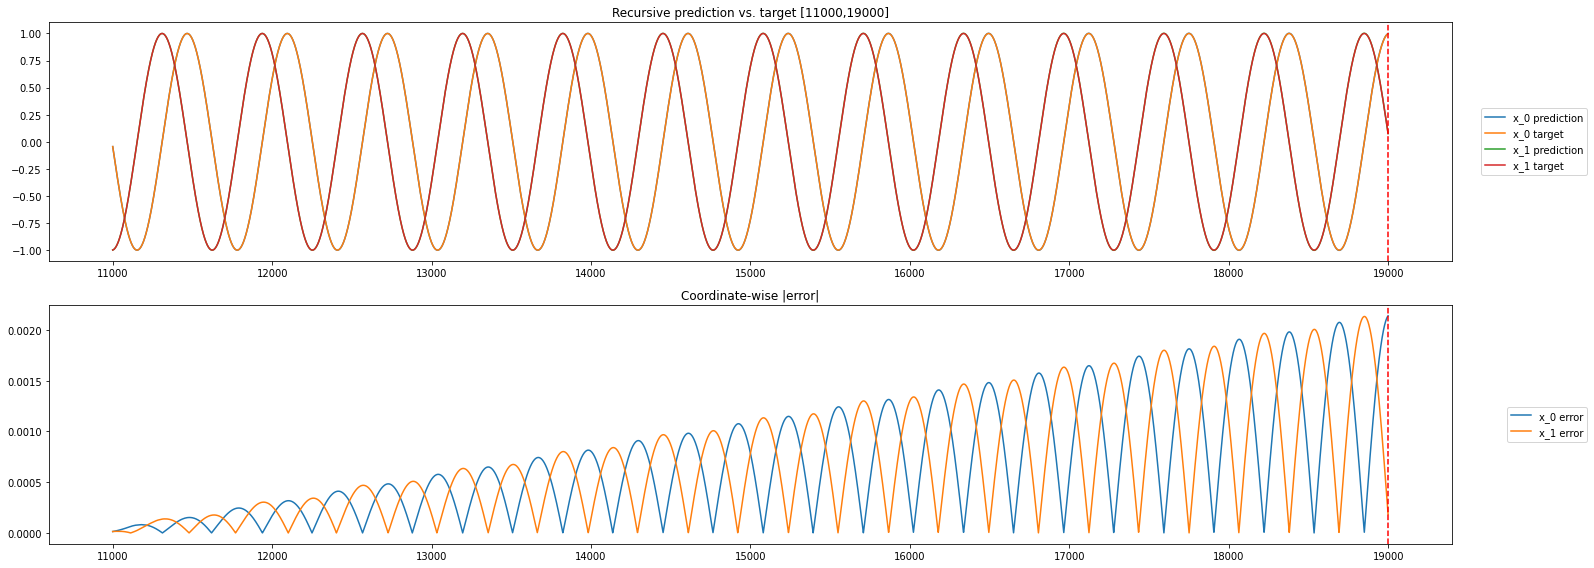

In [257]:
t_forward = 8000
model_rec_out = model.recursive_predict(true_data, train_start, train_end, t_forward)
# model_rec_out = model.recursive_predict(flawed_data, train_start, train_end, t_forward)

vt = validTime(0.2)(model_rec_out, true_target[test_start:test_start+t_forward])
# vt = validTime(0.2)(model_rec_out, flawed_target[test_start:test_start+t_forward])

print(f'valid time : {vt}')
print(f'NMSE       : {NMSE(model_rec_out, true_target[test_start:test_start+t_forward])}')
print(f'RMSE       : {RMSE(model_rec_out, true_target[test_start:test_start+t_forward])}')
print(f'NRMSE      : {NRMSE(model_rec_out, true_target[test_start:test_start+t_forward])}')
plotRecursiveComparison(model_rec_out, true_data, train_end, t_forward, vline_x=test_start+vt)
# plotRecursiveComparison(model_rec_out, flawed_data, train_end, t_forward, vline_x=test_start+vt)

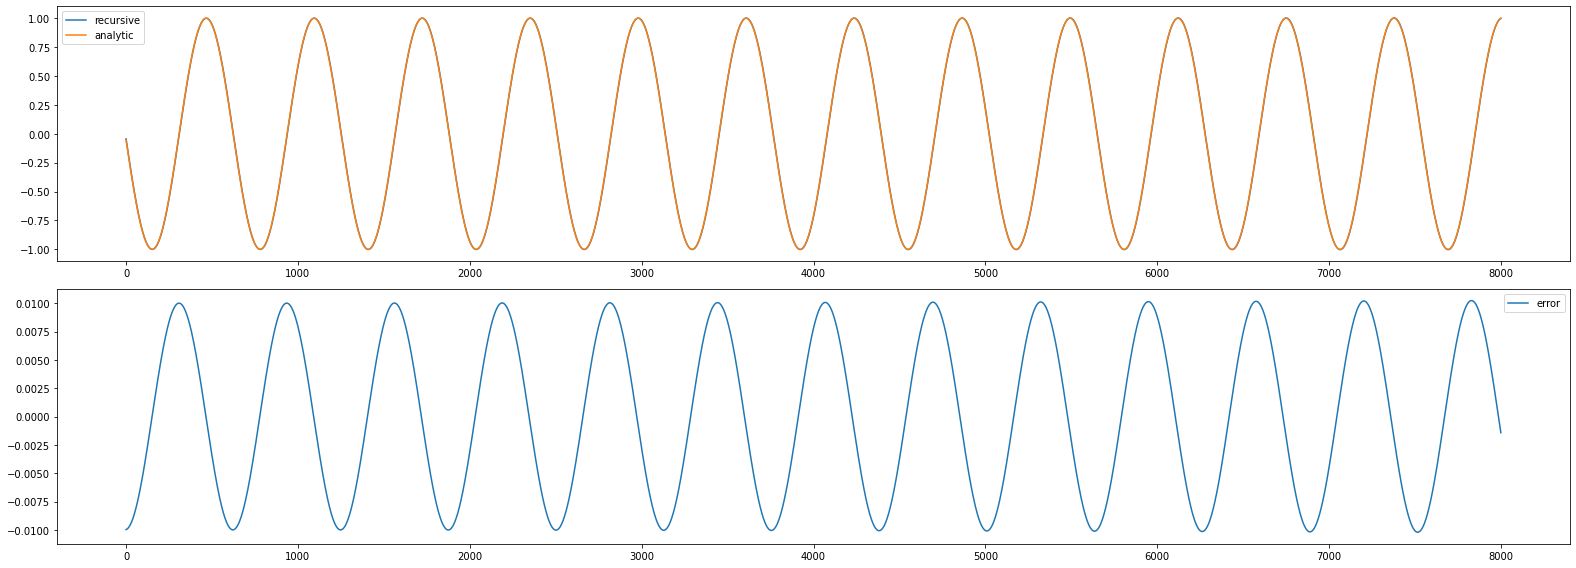

In [258]:
tf = int(t_forward*dt)
rec_x0 = true_data[train_end]
rec_true_data = solve_ivp(oneDSpring_ODE_integrable(m=m_true,k=k_true,b=b_true,F=F_true), (0, tf+dt), rec_x0, method='RK45', t_eval = np.arange(0,tf+dt,dt), max_step = 0.01, vectorized=True).y.T
# adj_true_data = euler(oneDSpring_ODE_integrable(m=m_true,k=k_true,b=b_true,F=F_true), flawed_x0, tf, 1e-4, 1e-2).y.T
rec_true_target = rec_true_data[1:]

fig, axs = plt.subplots(2, figsize=(22,8))
axs[0].plot(np.arange(t_forward), model_rec_out[:t_forward,0], label="recursive")
axs[0].plot(np.arange(t_forward), rec_true_target[:t_forward,0], label="analytic")
axs[1].plot(np.arange(t_forward), rec_true_target[:t_forward,0]-model_rec_out[:t_forward,0], label="error")
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()

Training on good data doesn't learn the "correct ODE". Potential for instability too

In [248]:
model.train(
        true_data,
        true_target,
        # flawed_data,
        # flawed_target,
        train_indices,
        dataLossFactor=0,
        ODELossFactor=1,
        # ODEFunc=oneDSpring_ODE_wrapper(m=m_true,k=k_true,b=b_true,F=F_true),
        ODEFunc=oneDSpring_ODE_wrapper(m=m_flawed,k=k_flawed,b=b_flawed,F=F_flawed),
        printResults=True
        )

                    MSE     NMSE             NRMSE     Loss Weighted Loss
Component                                                                
Data           0.000050 0.000050 2544755379.408056 0.499635      0.000000
ODE            0.000000 0.000000          0.000000 0.000000      0.000000
Regularization 0.000015 0.000015          0.003836 0.063130      0.000001
Total          0.000065 0.000065 2544755379.411892 0.562765      0.000001


valid time : 2203
NMSE       : 0.22702182345496272
RMSE       : 0.47646807180866996
NRMSE      : 214378483505.81595


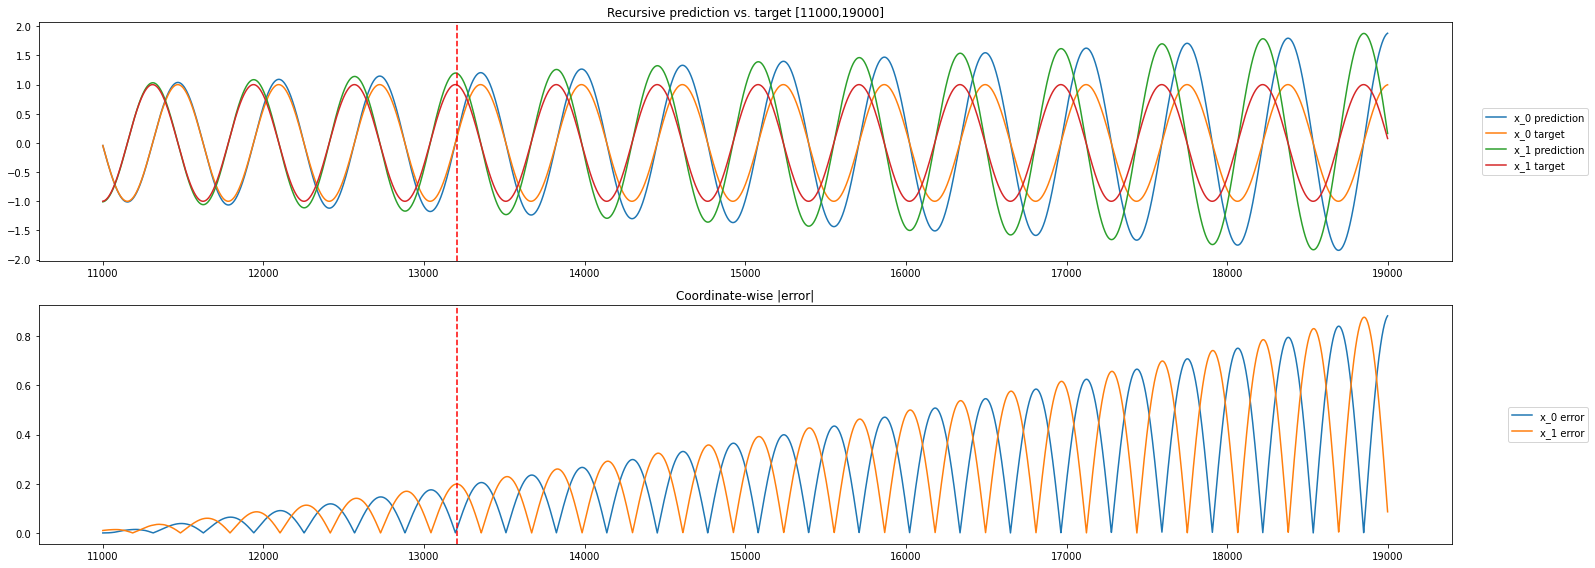

In [249]:
t_forward = 8000
model_rec_out = model.recursive_predict(true_data, train_start, train_end, t_forward)
# model_rec_out = model.recursive_predict(flawed_data, train_start, train_end, t_forward)

vt = validTime(0.2)(model_rec_out, true_target[test_start:test_start+t_forward])

print(f'valid time : {vt}')
print(f'NMSE       : {NMSE(model_rec_out, true_target[test_start:test_start+t_forward])}')
print(f'RMSE       : {RMSE(model_rec_out, true_target[test_start:test_start+t_forward])}')
print(f'NRMSE      : {NRMSE(model_rec_out, true_target[test_start:test_start+t_forward])}')
plotRecursiveComparison(model_rec_out, true_data, train_end, t_forward, vline_x=test_start+vt)

In [252]:
model.train(
        # true_data,
        # true_target,
        flawed_data,
        flawed_target,
        train_indices,
        dataLossFactor=1,
        ODELossFactor=0,
        # ODEFunc=oneDSpring_ODE_wrapper(m=m_true,k=k_true,b=b_true,F=F_true),
        ODEFunc=oneDSpring_ODE_wrapper(m=m_flawed,k=k_flawed,b=b_flawed,F=F_flawed),
        printResults=True
        )

                    MSE     NMSE    NRMSE     Loss Weighted Loss
Component                                                       
Data           0.000000 0.000000 0.000000 0.000000      0.000000
ODE            0.000049 0.000050 1.415457 0.493357      0.000000
Regularization 0.000015 0.000015 0.003817 0.062501      0.000001
Total          0.000064 0.000064 1.419274 0.555857      0.000001


valid time : 8000
NMSE       : 0.00010101108356301724
RMSE       : 0.010025222596959925
NRMSE      : 2.0200715987231908


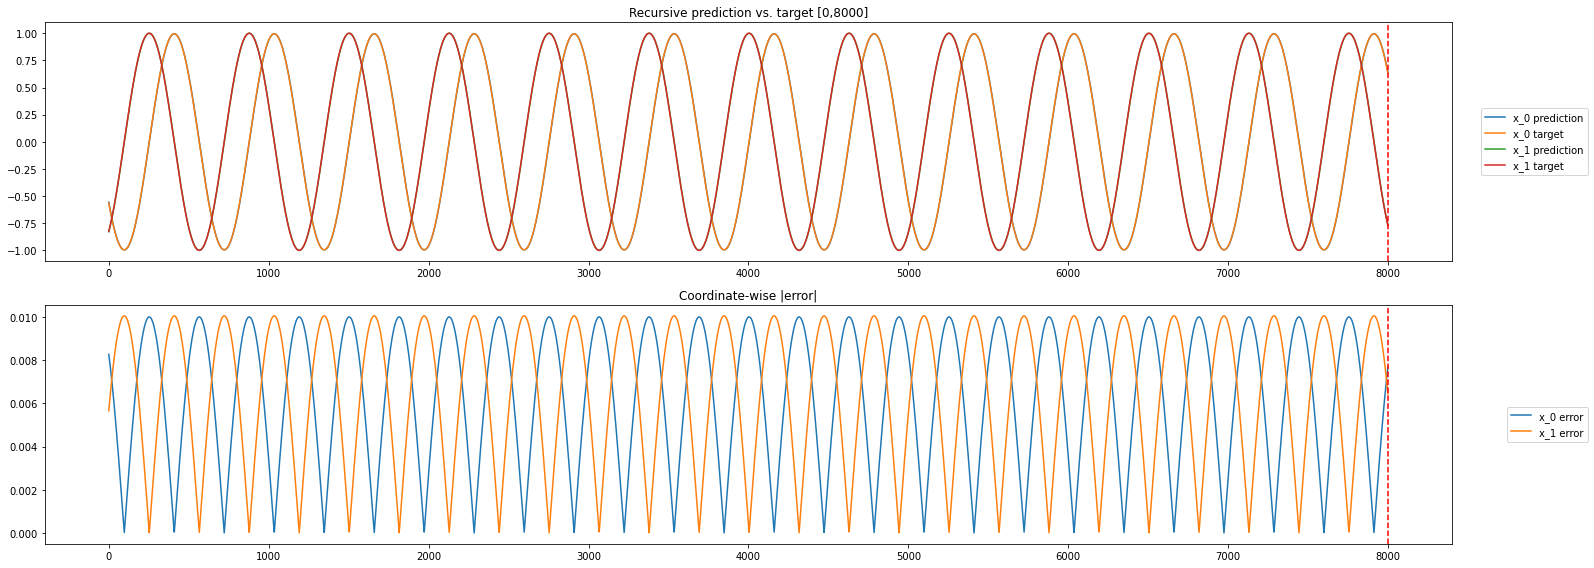

In [253]:
t_forward = 8000
tf = int(t_forward*dt)
# model_rec_out = model.recursive_predict(true_data, train_start, train_end, t_forward)
model_rec_out = model.recursive_predict(flawed_data, train_start, train_end, t_forward)

flawed_x0 = flawed_data[train_end]
# adj_true_data = solve_ivp(oneDSpring_ODE_integrable(m=m_true,k=k_true,b=b_true,F=F_true), (0, tf+dt), flawed_x0, method='RK45', t_eval = np.arange(0,tf+dt,dt), max_step = 0.01, vectorized=True).y.T
adj_true_data = solve_ivp(oneDSpring_ODE_integrable(m=m_flawed,k=k_flawed,b=b_flawed,F=F_flawed), (0, tf+dt), flawed_x0, method='RK45', t_eval = np.arange(0,tf+dt,dt), max_step = 0.01, vectorized=True).y.T
# adj_true_data = euler(oneDSpring_ODE_integrable(m=m_true,k=k_true,b=b_true,F=F_true), flawed_x0, tf, 1e-4, 1e-2).y.T
adj_true_target = adj_true_data[1:]

vt = validTime(0.2)(model_rec_out, adj_true_target[:t_forward])

print(f'valid time : {vt}')
print(f'NMSE       : {NMSE(model_rec_out, adj_true_target[:t_forward])}')
print(f'RMSE       : {RMSE(model_rec_out, adj_true_target[:t_forward])}')
print(f'NRMSE      : {NRMSE(model_rec_out, adj_true_target[:t_forward])}')
# plotRecursiveComparison(model_rec_out, true_data, train_end, t_forward, vline_x=test_start+vt)
plotRecursiveComparison(model_rec_out, adj_true_target, 0, t_forward, vline_x=vt)

In [254]:
model.train(
        # true_data,
        # true_target,
        flawed_data,
        flawed_target,
        train_indices,
        dataLossFactor=0,
        ODELossFactor=1,
        # ODEFunc=oneDSpring_ODE_wrapper(m=m_true,k=k_true,b=b_true,F=F_true),
        ODEFunc=oneDSpring_ODE_wrapper(m=m_flawed,k=k_flawed,b=b_flawed,F=F_flawed),
        printResults=True
        )

                    MSE     NMSE    NRMSE     Loss Weighted Loss
Component                                                       
Data           0.000000 0.000000 0.010582 0.000028      0.000000
ODE            0.000000 0.000000 0.000000 0.000000      0.000000
Regularization 0.000015 0.000015 0.003817 0.062503      0.000001
Total          0.000015 0.000015 0.014399 0.062530      0.000001


valid time : 8000
NMSE       : 0.00010428191118887132
RMSE       : 0.010186242249594957
NRMSE      : 2.05251688599521


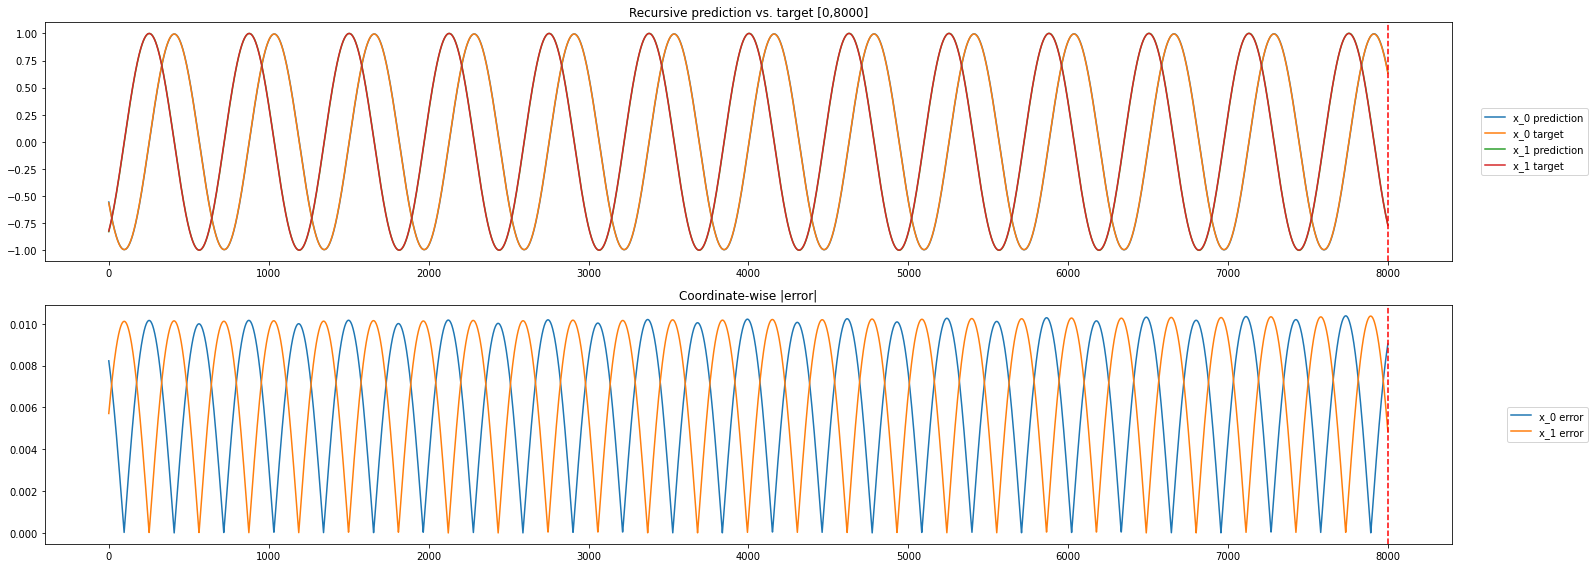

In [255]:
t_forward = 8000
tf = int(t_forward*dt)
# model_rec_out = model.recursive_predict(true_data, train_start, train_end, t_forward)
model_rec_out = model.recursive_predict(flawed_data, train_start, train_end, t_forward)

flawed_x0 = flawed_data[train_end]
# adj_true_data = solve_ivp(oneDSpring_ODE_integrable(m=m_true,k=k_true,b=b_true,F=F_true), (0, tf+dt), flawed_x0, method='RK45', t_eval = np.arange(0,tf+dt,dt), max_step = 0.01, vectorized=True).y.T
adj_true_data = solve_ivp(oneDSpring_ODE_integrable(m=m_flawed,k=k_flawed,b=b_flawed,F=F_flawed), (0, tf+dt), flawed_x0, method='RK45', t_eval = np.arange(0,tf+dt,dt), max_step = 0.01, vectorized=True).y.T
# adj_true_data = euler(oneDSpring_ODE_integrable(m=m_true,k=k_true,b=b_true,F=F_true), flawed_x0, tf, 1e-4, 1e-2).y.T
adj_true_target = adj_true_data[1:]

vt = validTime(0.2)(model_rec_out, adj_true_target[:t_forward])

print(f'valid time : {vt}')
print(f'NMSE       : {NMSE(model_rec_out, adj_true_target[:t_forward])}')
print(f'RMSE       : {RMSE(model_rec_out, adj_true_target[:t_forward])}')
print(f'NRMSE      : {NRMSE(model_rec_out, adj_true_target[:t_forward])}')
# plotRecursiveComparison(model_rec_out, true_data, train_end, t_forward, vline_x=test_start+vt)
plotRecursiveComparison(model_rec_out, adj_true_target, 0, t_forward, vline_x=vt)

Constructing the state from flawed data and training only on the correct gives inferior recursive prediction

In [250]:
model.train(
        # true_data,
        # true_target,
        flawed_data,
        flawed_target,
        train_indices,
        dataLossFactor=0,
        ODELossFactor=1,
        ODEFunc=oneDSpring_ODE_wrapper(m=m_true,k=k_true,b=b_true,F=F_true),
        # ODEFunc=oneDSpring_ODE_wrapper(m=m_flawed,k=k_flawed,b=b_flawed,F=F_flawed),
        printResults=True
        )

                    MSE     NMSE    NRMSE     Loss Weighted Loss
Component                                                       
Data           0.000049 0.000049 1.408302 0.488479      0.000000
ODE            0.000000 0.000000 0.000000 0.000000      0.000000
Regularization 0.000014 0.000014 0.003798 0.061884      0.000001
Total          0.000063 0.000064 1.412100 0.550364      0.000001


valid time : 2415
NMSE       : 0.11608887091389042
RMSE       : 0.34019114655121707
NRMSE      : 153177836516.9769


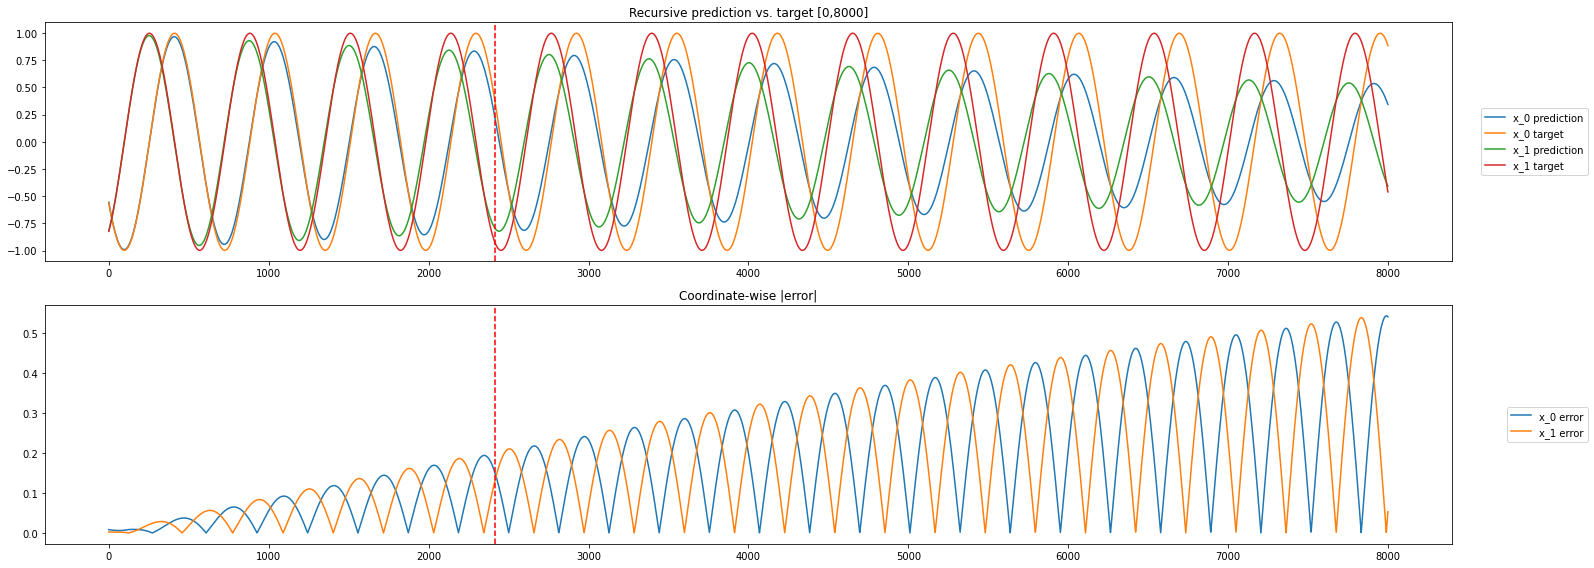

In [251]:
t_forward = 8000
tf = int(t_forward*dt)
# model_rec_out = model.recursive_predict(true_data, train_start, train_end, t_forward)
model_rec_out = model.recursive_predict(flawed_data, train_start, train_end, t_forward)

flawed_x0 = flawed_data[train_end]
adj_true_data = solve_ivp(oneDSpring_ODE_integrable(m=m_true,k=k_true,b=b_true,F=F_true), (0, tf+dt), flawed_x0, method='RK45', t_eval = np.arange(0,tf+dt,dt), max_step = 0.01, vectorized=True).y.T
# adj_true_data = euler(oneDSpring_ODE_integrable(m=m_true,k=k_true,b=b_true,F=F_true), flawed_x0, tf, 1e-4, 1e-2).y.T
adj_true_target = adj_true_data[1:]

vt = validTime(0.2)(model_rec_out, adj_true_target[:t_forward])

print(f'valid time : {vt}')
print(f'NMSE       : {NMSE(model_rec_out, adj_true_target[:t_forward])}')
print(f'RMSE       : {RMSE(model_rec_out, adj_true_target[:t_forward])}')
print(f'NRMSE      : {NRMSE(model_rec_out, adj_true_target[:t_forward])}')
# plotRecursiveComparison(model_rec_out, true_data, train_end, t_forward, vline_x=test_start+vt)
plotRecursiveComparison(model_rec_out, adj_true_target, 0, t_forward, vline_x=vt)